In [6]:
from pathlib import Path
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np

# I/O

In [7]:
data_dir = Path('../examples/data')
sites = ('soldanesti_aval', 'soldanesti_amonte', 'saveni_aval', 'saveni_amonte')
models = ('future', 'past')
future_gdf = pd.concat([
    gpd.read_file(data_dir / site / f'estimation_surface_output_future.fgb')[['estimated_sum', 'truth_sum', 'error', 'geometry']] for site in sites
], ignore_index=True)
past_gdf = pd.concat([
    gpd.read_file(data_dir / site / f'estimation_surface_output_past.fgb')[['estimated_sum', 'truth_sum', 'error', 'geometry']] for site in sites
], ignore_index=True)

future_gdf['model'] = 'future'
past_gdf['model'] = 'past'
gdf = pd.concat([future_gdf, past_gdf], ignore_index=True)
gdf['area'] = gdf.area
gdf.rename(columns={'estimated_sum': 'estimated', 'truth_sum': 'truth'}, inplace=True)
gdf['residuals'] = (gdf['estimated'] - gdf['truth']).abs()

In [8]:
for model in models:
    print(model)
    print(gdf.loc[gdf['model'] == model, 'error'].describe(), end='\n\n')

future
count    27.000000
mean      0.374672
std       0.388803
min       0.023022
25%       0.148546
50%       0.288438
75%       0.489167
max       2.015368
Name: error, dtype: float64

past
count    27.000000
mean      0.369298
std       0.260867
min       0.006312
25%       0.150951
50%       0.350594
75%       0.505174
max       0.978855
Name: error, dtype: float64



# Y vs Yhat

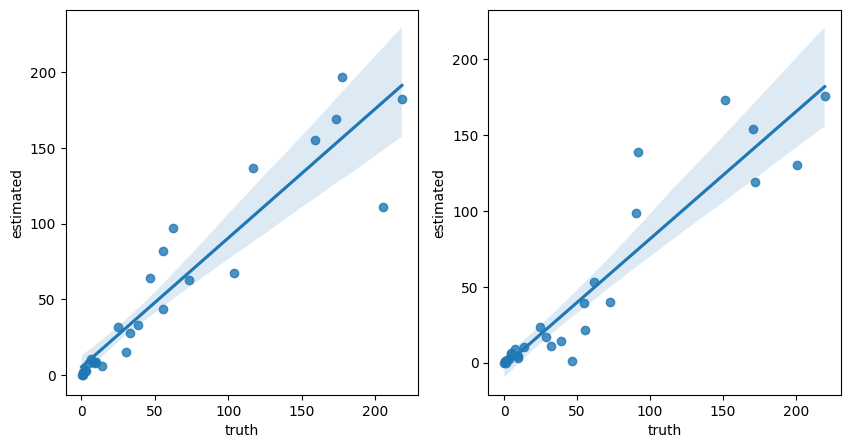

In [9]:
fig = plt.figure(figsize=(10, 5))

for i, model in enumerate(models, start=1):
    model_gdf = gdf[gdf['model'] == model]
    ax = fig.add_subplot(1, 2, i)
    seaborn.regplot(x=model_gdf['truth'], y=model_gdf['estimated'], ax=ax)

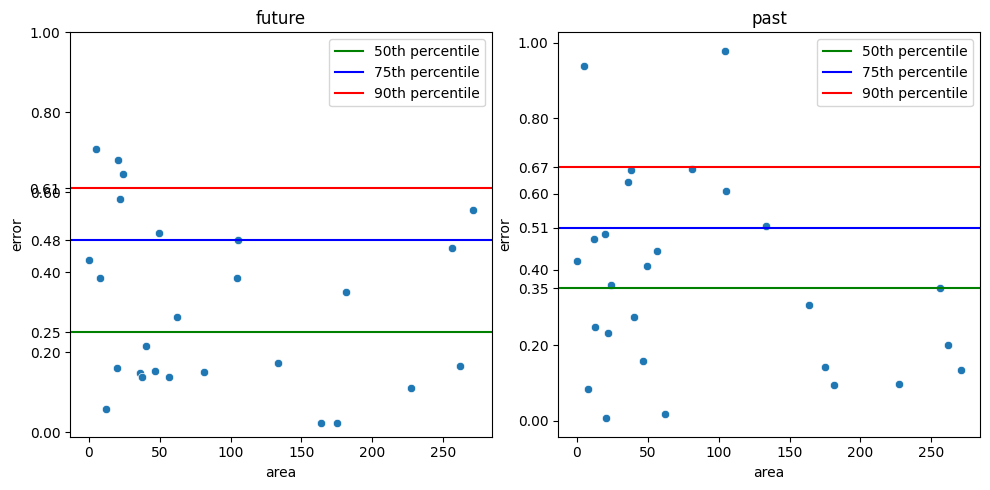

In [10]:
fig = plt.figure(figsize=(10, 5))

for i, model in enumerate(models, start=1):
    model_gdf = gdf[gdf['model'] == model]
    model_gdf = model_gdf[model_gdf['error'] < 2]
    ax = fig.add_subplot(1, 2, i)
    seaborn.scatterplot(x=model_gdf['area'], y=model_gdf['error'], ax=ax)
    y_ticks = list(np.arange(0, 1.2, 0.2))

    for percentile, color in zip((50, 75, 90), ('green', 'blue', 'red')):
        value = np.round(np.percentile(model_gdf['error'], percentile), 2)
        ax.axhline(value, label=f'{percentile}th percentile', c=color)
        # ax.annotate(str(value), (260, value+0.01), annotation_clip=False)
        y_ticks.append(value)
    ax.set_title(model)
    ax.legend()
    plt.tight_layout()
    ax.set_yticks(y_ticks)